In [1]:
!nvidia-smi

Mon Sep  5 08:22:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |      0MiB / 15360MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

  Using cached tflite_model_maker-0.4.0-py3-none-any.whl (642 kB)
  Using cached scann-1.2.7-cp37-cp37m-manylinux_2_27_x86_64.whl (11.2 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached tflite_support-0.4.2-cp37-cp37m-manylinux2014_x86_64.whl (60.2 MB)
  Using cached fire-0.4.0-py2.py3-none-any.whl
  Using cached tf_models_official-2.3.0-py2.py3-none-any.whl (840 kB)
  Using cached tensorflowjs-3.20.0-py3-none-any.whl (81 kB)
  Using cached numba-0.53.0-cp37-cp37m-manylinux2014_x86_64.whl (3.4 MB)
  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached neural_structured_learning-1.4.0-py2.py3-none-any.whl (128 kB)
  Using cached tensorflow_addons-0.17.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached resampy-0.4.0-py3-none-any.whl (3.1 MB)
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)
  Using cached audioread-3.0.0-py3-none-any.whl
  Using cached pooch-1.6.0-py3-none-any.whl

In [3]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('/home/jupyter/notebook-javi/object_detection/annotations/annotation.csv')
df['image_name'] = '/home/jupyter/notebook-javi/object_detection/images/' + df.img_filename
df = df.rename(columns={'ann_bbox_xmin':'x_min', 'ann_bbox_ymin':'y_min', 'ann_bbox_xmax': 'x_max', 'ann_bbox_ymax': 'y_max', 'cat_name': 'class_name'})
df = df[['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']]
df

image_name       x_min  \
0     /home/jupyter/notebook-javi/object_detection/i...  146.400256   
1     /home/jupyter/notebook-javi/object_detection/i...    0.000000   
2     /home/jupyter/notebook-javi/object_detection/i...  311.680000   
3     /home/jupyter/notebook-javi/object_detection/i...   12.961792   
4     /home/jupyter/notebook-javi/object_detection/i...  177.600512   
...                                                 ...         ...   
1157  /home/jupyter/notebook-javi/object_detection/i...   68.787789   
1158  /home/jupyter/notebook-javi/object_detection/i...  489.331302   
1159  /home/jupyter/notebook-javi/object_detection/i...    0.000000   
1160  /home/jupyter/notebook-javi/object_detection/i...  547.200000   
1161  /home/jupyter/notebook-javi/object_detection/i...    0.000000   

           y_min        x_max       y_max class_name  
0       2.400000   865.599488  767.199744        Cat  
1       0.000000   777.600000  492.000000        Hat  
2       5.120256   910.720000  626.559744        Cat  
3      41.656810  1023.074304  720.200605        Cat  
4     222.399744   838.400000  593.600256        Cat  
...          ...          ...         ...        ...  
1157   56.384618   501.838162  634.326941        Cat  
1158  191.081203   988.042752  720.470098        Cat  
1159    0.000000   601.600000  768.000000        Cat  
1160   96.000000  1024.000000  768.000000        Cat  
1161    0.000000  1022.284728  881.000000        Cat  

[1162 rows x 6 columns]

In [5]:
df.x_min = df.x_min.apply(int)
df.y_min = df.y_min.apply(int)
df.x_max = df.x_max.apply(int)
df.y_max = df.y_max.apply(int)

In [6]:
def show_image_objects(image_row):

    img_path = image_row.image_name
    box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]

    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(255, 255, 0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [7]:
show_image_objects(df.iloc[5])

In [8]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [9]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [10]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [11]:
classes = set(df['class_name'])

with open(CLASSES_FILE, 'w') as f:
    for i, line in enumerate(sorted(classes)):
        f.write('{},{}\n'.format(line,i))

In [12]:
!head classes.csv

Alarm clock,0
Animal,1
Bat (Animal),2
Bidet,3
Billboard,4
Bird,5
Book,6
Bottle,7
Bowl,8
Box,9


In [13]:
PRETRAINED_MODEL = '/home/jupyter/notebook-javi/object_detection/keras-retinanet/snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to /home/jupyter/notebook-javi/object_detection/keras-retinanet/snapshots/_pretrained_model.h5


In [14]:
!/home/jupyter/notebook-javi/object_detection/keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 64 --epochs 4 csv annotations.csv classes.csv

Creating model, this may take a second...
2022-09-05 08:24:15.440784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:24:15.637247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:24:15.639119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:24:15.641323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Tens

In [15]:
!ls snapshots

resnet50_csv_01.h5  resnet50_csv_02.h5	resnet50_csv_03.h5  resnet50_csv_04.h5


In [16]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_04.h5


2022-09-05 08:39:22.130417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:39:22.143378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:39:22.145196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 08:39:22.147560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
def predict(image):
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
    )

    boxes /= scale


    return boxes, scores, labels

In [122]:
THRES_SCORE = 0.60

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        print(label)
        print(score)
        print(box)
        
        if score < THRES_SCORE:
            print(label)
            print(score)
            print(box)
            break

        color = label_color(label)
        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [123]:
def show_detected_objects(image_row):
    img_path = image_row.image_name

    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]
    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()


In [124]:
test_df.head(n=10)

image_name  x_min  y_min  x_max  \
244   /home/jupyter/notebook-javi/object_detection/i...    144    296    210   
101   /home/jupyter/notebook-javi/object_detection/i...    711    403    934   
1080  /home/jupyter/notebook-javi/object_detection/i...     65     16   1024   
583   /home/jupyter/notebook-javi/object_detection/i...    252    110   1020   
752   /home/jupyter/notebook-javi/object_detection/i...    200     18    663   
715   /home/jupyter/notebook-javi/object_detection/i...      1      7    932   
712   /home/jupyter/notebook-javi/object_detection/i...      0      0   1024   
174   /home/jupyter/notebook-javi/object_detection/i...      0      0    732   
367   /home/jupyter/notebook-javi/object_detection/i...    303     29    820   
554   /home/jupyter/notebook-javi/object_detection/i...    256    252    318   

      y_max     class_name  
244     340           Food  
101     753          Chair  
1080    752            Cat  
583     678           Lynx  
752     683            Cat  
715    1024  Cat furniture  
712     682            Cat  
174    1022            Cat  
367     684            Cat  
554     316          Wheel

12
0.6801057
[143.75879 113.19427 646.49    676.5681 ]
55
0.23816328
[ 71.09965  52.44637 739.7114  658.953  ]
55
0.23816328
[ 71.09965  52.44637 739.7114  658.953  ]


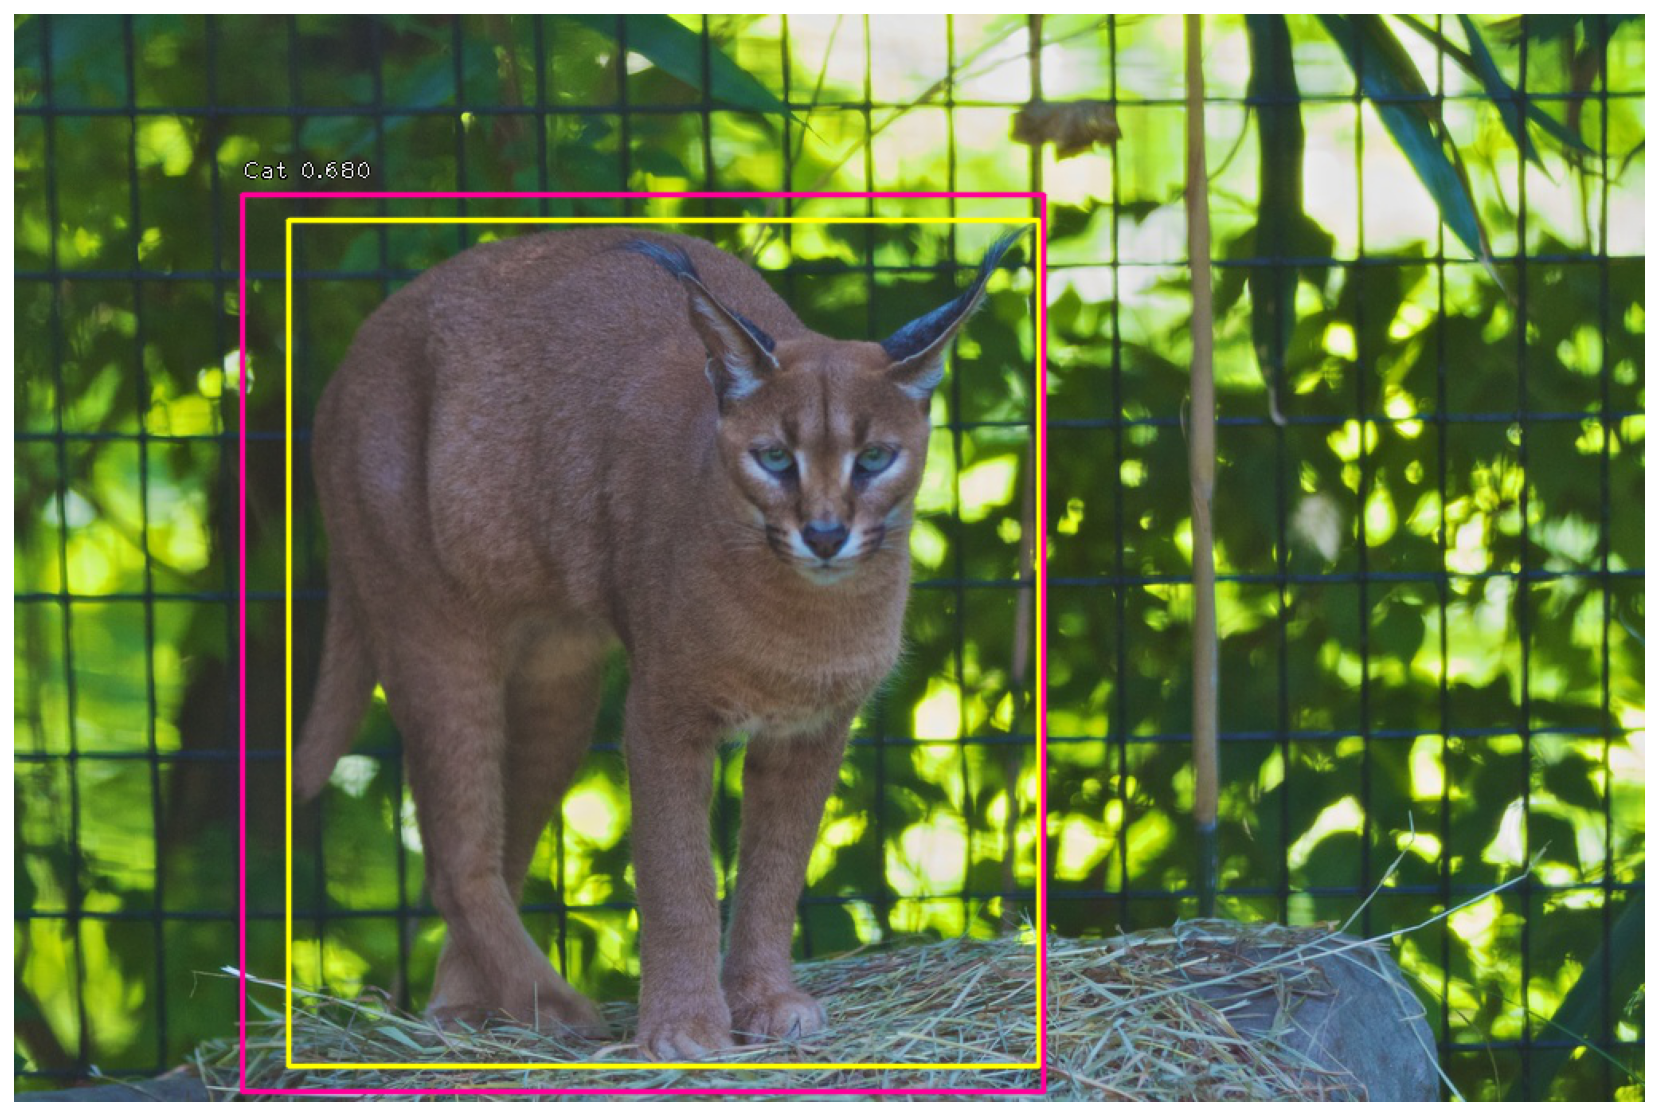

In [127]:
show_detected_objects(test_df.iloc[61])